# Questions:

- [x] What is the average bandwidth of every device? The average of these averages?
- [x] What are the distributions of these bandwidths?
- [x] What percentage of messages reach everyone?
- [x] How long does it take for a message to reach everyone?
    - pick a particular msg. x axis is time, y is % of people that have received it
- [ ] Do loops ever occur?


TODO: add option to turn message expiration on and off in simulator

- in real life, you could continue storing the hash of messages past 5 min (in a separate DS like a bloom filter or a much larger bitlist that is not ever shared)

---

make graph:
- x axis: number of people
- y axis: 90/5th percentile communication bandwidth

    - do this for 3 ft apart, 5 ft apart, etc
    
make graph:
- x: distance apart
- y: how many people in network until bandwidth limit is reached

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plorts
import random

## Data Cleaning

In [93]:
NUM_DEVICES = 3000
NUM_ROUNDS = 3000
BITLIST_INTERVAL = 10000
MINUTES = 5
MOVE = False
UNIFORM = True
UNIFORM_SPACING = 15
SEND_RATE = 30000

FILE_PATH = '../python/processing/logs/minutes_{minutes}_numDevices_{num_devices}_bitListInterval_{bitlist_interval}_move_{move}_uniform_{uniform}_uniformSpacing_{uniform_spacing}_sendRate_{send_rate}.csv'.format(
    minutes=MINUTES,
    num_devices=NUM_DEVICES,
    bitlist_interval=BITLIST_INTERVAL,
    move=MOVE,
    uniform=UNIFORM,
    uniform_spacing=UNIFORM_SPACING,
    send_rate=SEND_RATE)

FIGURES_PATH = './Figures/minutes_{minutes}_numDevices_{num_devices}_bitListInterval_{bitlist_interval}_move_{move}_uniform_{uniform}_uniformSpacing_{uniform_spacing}_sendRate_{send_rate}/'.format(
    minutes=MINUTES,
    num_devices=NUM_DEVICES,
    bitlist_interval=BITLIST_INTERVAL,
    move=MOVE,
    uniform=UNIFORM,
    uniform_spacing=UNIFORM_SPACING,
    send_rate=SEND_RATE)

# TODO write function that aggregates incoming and outgoing

def read_messages(file, usecols=[]):
    types = {'sender': 'Int64',
             'receiver': 'Int64',
             'type': 'str',
             'msg_id': 'Int64',
             'transmission_id': 'Int64',
             'size': 'Int64',
             'time': 'Int64',
             'sim_id': 'Int64'}

    if (len(usecols) == 0):
        df = pd.read_csv(file, na_values=['None'], dtype=types, low_memory=False)
    else:
        df = pd.read_csv(file, na_values=[
                         'None'], dtype=types, low_memory=False, usecols=usecols)

    return df

In [4]:
df = read_messages(FILE_PATH)

In [5]:
def get_outgoing_bandwidth(df):
    tmp = df[['sender', 'time', 'transimission_id', 'size']]
    tmp = tmp.groupby(['sender', 'time', 'transimission_id'], as_index=False).min()
    tmp['seconds'] = tmp['time'] // 1000 # if this doesn't round down do .apply(np.floor)
    tmp = tmp.groupby(['sender', 'seconds']).sum()
    tmp = tmp.reset_index()
    result = tmp[['sender', 'seconds', 'size']].copy()
    result.columns = ['Device', 'Seconds', 'Bytes']
    result['MB'] = result['Bytes'] / 1000000
    return result

outgoing = get_outgoing_bandwidth(df)

In [6]:
def get_incoming_bandwidth(df):
    tmp = df[['receiver', 'time', 'size']].copy()
    tmp['seconds'] = tmp['time'] // 1000
    tmp = tmp.groupby(['receiver', 'seconds']).sum()
    tmp = tmp.reset_index()
    result = tmp[['receiver', 'seconds', 'size']].copy()
    result.columns = ['Device', 'Seconds', 'Bytes']
    result['MB'] = result['Bytes'] / 1000000
    return result

In [8]:
def read_incoming_bandwidth(file_path):
    df = read_messages(file_path, usecols=['receiver', 'time', 'size'])
    
    df.loc[:,'time'] = df['time'] // 1000
    df = df.groupby(['receiver', 'time']).sum()
    df = df.reset_index()
    df.loc[:,'size'] = df['size'] / 1000000
    df.columns = ['Device', 'Seconds', 'MB']
    return df
    

In [28]:
def process_incoming_chunk(df):
    df.loc[:,'time'] = df['time'] // 1000
    df = df.groupby(['receiver', 'time']).sum()
    df = df.reset_index()
    df.columns = ['Device', 'Seconds', 'Bytes']
    return df

def read_incoming_bandwidth_chunked(file_path):
    types = {'sender': 'Int64',
             'receiver': 'Int64',
             'type': 'str',
             'msg_id': 'Int64',
             'transmission_id': 'Int64',
             'size': 'Int64',
             'time': 'Int64',
             'sim_id': 'Int64'}

    dfs = []
    chunksize = 10 ** 6
    with pd.read_csv(file_path, chunksize=chunksize, usecols=['receiver', 'time', 'size'], dtype=types) as reader:
        for chunk in reader:
            dfs += [process_incoming_chunk(chunk)]
    
    # To handle duplicate (Device, Seconds) key pairs in two dfs (msg split across chunks), sum them.
    # i.e. for stitching, just concat them all together, do another identical groupby and sum.
    # Do this on Bytes and then convert to MB to avoid floating point problems.
    df = pd.concat(dfs)
    df = df.groupby(['Device', 'Seconds']).sum()
    df = df.reset_index()
    df.loc[:,'Bytes'] = df['Bytes'] / 1000000
    df.rename(columns = {'Bytes':'MB'}, inplace = True) 
    return df


In [27]:
df = read_messages(FILE_PATH)
in1 = get_incoming_bandwidth(df)
in2 = read_incoming_bandwidth(FILE_PATH)
in3 = read_incoming_bandwidth_chunked(FILE_PATH)

display(in2.equals(in1[['Device', 'Seconds', 'MB']]))
display(in3.equals(in1[['Device', 'Seconds', 'MB']]))

True

True

In [31]:
def read_outgoing_bandwidth(file_path):
    df = read_messages(file_path, usecols=['sender', 'time', 'transimission_id', 'size'])
    df = df.groupby(['sender', 'time', 'transimission_id'], as_index=False).min()
    df.loc[:,'time'] = df['time'] // 1000
    df = df.groupby(['sender', 'time']).sum()
    df = df.reset_index()
    df.drop(['transimission_id'], axis=1, inplace=True)
    df.columns = ['Device', 'Seconds', 'Bytes']
    df.loc[:,'Bytes'] = df['Bytes'] / 1000000
    df.rename(columns = {'Bytes':'MB'}, inplace = True)
    
    return df

In [69]:
def process_outgoing_chunk(df):
    df = df.groupby(['sender', 'time', 'transimission_id'], as_index=False).min()
    df.loc[:,'time'] = df['time'] // 1000
    df = df.groupby(['sender', 'time']).sum()
    df = df.reset_index()
    df.drop(['transimission_id'], axis=1, inplace=True)
    df.columns = ['Device', 'Seconds', 'Bytes']
    return df

def read_outgoing_bandwidth_chunked(file_path):
    types = {'sender': 'Int64',
             'receiver': 'Int64',
             'type': 'str',
             'msg_id': 'Int64',
             'transmission_id': 'Int64',
             'size': 'Int64',
             'time': 'Int64',
             'sim_id': 'Int64'}

    dfs = []
    chunksize = 10 ** 6
    with pd.read_csv(file_path, chunksize=chunksize, usecols=['sender', 'time', 'transimission_id', 'size'], dtype=types) as reader:
        prev = pd.DataFrame()
        for chunk in reader:
            # problems happen if a transmission id is split across chunks
            if (prev.empty):
                prev = chunk
                continue
            else:
                # check if a transmission is split across 2 chunks
                last_prev_id = prev.iloc[-1]['transimission_id']
                first_chunk_id = chunk.iloc[0]['transimission_id']

                if (last_prev_id == first_chunk_id):
                
                    chunk = pd.concat([prev[prev['transimission_id'] == last_prev_id], chunk])
                    prev = prev[prev['transimission_id'] != last_prev_id]
                    dfs += [process_outgoing_chunk(prev)]
                    prev = chunk
                    
                else:
                    dfs += [process_outgoing_chunk(prev)]
                    prev = chunk
            
        dfs += [process_outgoing_chunk(chunk)]
    
    # To handle duplicate (Device, Seconds) key pairs in two dfs (msg split across chunks), sum them.
    # i.e. for stitching, just concat them all together, do another identical groupby and sum.
    # Do this on Bytes and then convert to MB to avoid floating point problems.
    df = pd.concat(dfs)
    df = df.groupby(['Device', 'Seconds']).sum()
    df = df.reset_index()
    df.loc[:,'Bytes'] = df['Bytes'] / 1000000
    df.rename(columns = {'Bytes':'MB'}, inplace = True)
    
    return df


In [70]:
# df = read_messages(FILE_PATH)
# out1 = get_outgoing_bandwidth(df)
# out2 = read_outgoing_bandwidth(FILE_PATH)
# out3 = read_outgoing_bandwidth_chunked(FILE_PATH)

# display(out2.equals(out1[['Device', 'Seconds', 'MB']]))
# display(out3.equals(out1[['Device', 'Seconds', 'MB']]))

True

True

In [94]:
in3 = read_incoming_bandwidth_chunked(FILE_PATH)
out3 = read_outgoing_bandwidth_chunked(FILE_PATH)

In [103]:
def combine_in_out(in_df, out_df):    
    combined = pd.concat([in_df, out_df])
    combined = combined.groupby(['Device', 'Seconds']).sum()
    combined = combined.reset_index()
    return combined

res = combine_in_out(in3, out3)
display(res)

,Device,Seconds,MB
0,0,1,0.000098
1,0,2,0.007778
2,0,3,0.007296
3,0,4,0.000050
4,0,8,0.000100
...,...,...,...
799767,2999,292,0.001328
799768,2999,293,0.228740
799769,2999,294,0.024957
799770,2999,295,0.032867


## Sanity Check

In [7]:
def verify_activity_at_all_rounds(df):
    for i in range(0, NUM_ROUNDS * 100, 100):
        if (len(df[df['time'] == i]) == 0):
            print('no activity at time {time}'.format(time=i))

In [8]:
# verify_activity_at_all_rounds(df)

## Bandwidth Summary

In [93]:
def print_statistics(bandwidths):
    avg_bandwidth = bandwidths['MB'].mean()
    min_bandwidth = bandwidths['MB'].min()
    max_bandwidth = bandwidths['MB'].max()

    print('Average MB/sec: {b}'.format(b=avg_bandwidth))
    print('Min MB/sec: {b}'.format(b=min_bandwidth))
    print('Max MB/sec: {b}'.format(b=max_bandwidth))

In [149]:
def plot_bandwidth_pdf(df, col, bins, direction):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel(col)
    ax.set_ylabel('% Data')
    ax.set_title('{direction} PDF'.format(direction=direction))
    
    ys, xs = np.histogram(df[col], bins=bins)
    ys = np.array(ys) / sum(ys) * 100
    
    plt.plot(xs[:-1], ys) # ignore end of last bucket
    
    plt.savefig(FIGURES_PATH + '{direction}_bandwidth_pdf.png'.format(direction=direction))
    
    plt.show()
    

In [151]:
def plot_bandwidth_cdf(df, col, direction):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel(col)
    ax.set_ylabel('% Data')
    ax.set_title('{direction} PDF'.format(direction=direction))
    
    sorted_data = np.sort(df[col])
    sorted_data_cdf = np.arange(len(sorted_data))/float(len(sorted_data)) * 100 
    plt.plot(sorted_data, sorted_data_cdf)
    
    plt.savefig(FIGURES_PATH + '{direction}_bandwidth_cdf.png'.format(direction=direction))
    
    plt.show()
    

### Incoming

In [94]:
print_statistics(incoming)

Average MB/sec: 0.048424157634303876
Min MB/sec: 4.9e-05
Max MB/sec: 0.427556


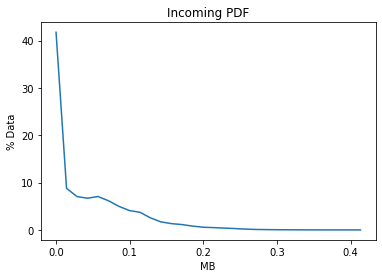

In [150]:
plot_bandwidth_pdf(incoming, 'MB', 30, 'Incoming')

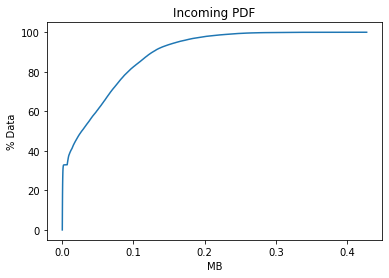

In [154]:
plot_bandwidth_cdf(incoming, 'MB', 'Incoming')

### Outgoing

In [97]:
print_statistics(outgoing)

Average MB/sec: 0.008671776786835034
Min MB/sec: 4.9e-05
Max MB/sec: 0.143616


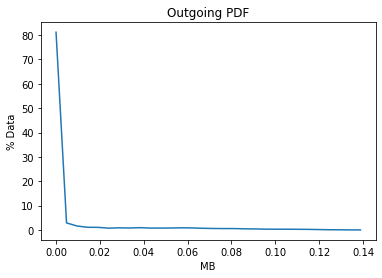

In [146]:
plot_bandwidth_pdf(outgoing, 'MB', 30, 'Outgoing')

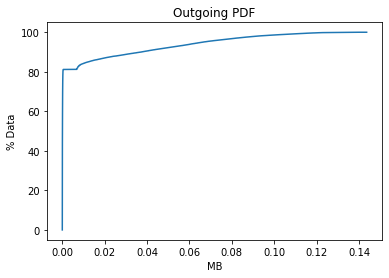

In [155]:
plot_bandwidth_cdf(outgoing, 'MB', 'Outgoing')

## Message Delivery Percentage

In [14]:
devices = set(np.array(df['sender']))
msg_ids = set(np.array(df['msg_id']))

msg_ids.remove(pd.NA)

In [15]:
missing = {}
num_missing = 0
for msg_id in msg_ids:
    for receiver in devices:
        entries = df[(df['receiver'] == receiver) & (df['msg_id'] == msg_id)]
        if (len(entries) == 0):
            if (msg_id in missing):
                missing[msg_id] += [receiver]
            else:
                missing[msg_id] = [receiver]


KeyboardInterrupt: 

In [ ]:
print('{num_missing} / {total} messages were not delivered to all nodes'.format(
    num_missing=len(missing), total=len(msg_ids)))

print(missing)

## Message Delivery Time

- Does it matter what time it is in the simulation? i.e. is it more congested later on and then takes longer to deliver?

In [123]:
# TODO this assumes that the rows are sorted on time (i think they are...)
def cdf_received_points(sender_id, msg_id):

    received = set()
    received.add(sender_id)

    time_series = df[df['msg_id'] == msg_id][['receiver', 'time']]
    
    start_time = time_series['time'].iloc[0]

    points = {}
    count = 1 # sender already added

    for receiver, time in time_series.values:
        time -= start_time
        # not already received
        if (receiver not in received):
            received.add(receiver)
            count += 1
        points[time] = count

    points_list = [(k, points[k]) for k in sorted(points, key=points.get, reverse=False)]
    xs, ys = zip(*points_list)

    xs = [x / 1000 for x in xs]
    ys = [100 * y / NUM_DEVICES for y in ys]
    
    return xs, ys

In [73]:
sender_message_pairs = df.groupby('msg_id').first().reset_index()[['sender', 'msg_id']].values

In [131]:
def plot_group_received_points(sender_message_pairs, start, end):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('seconds')
    ax.set_ylabel('% devices')
    ax.set_title('Message Delivery CDF')
    
    cmap = plt.cm.get_cmap('hsv', end - start)
    for idx in range(start, end):
        xs, ys = cdf_received_points(sender_message_pairs[idx][0], sender_message_pairs[idx][1])
        ax.step(xs, ys, color=cmap(idx))
    plt.savefig(FIGURES_PATH + 'message_deliver_cdf.png')
    plt.show()

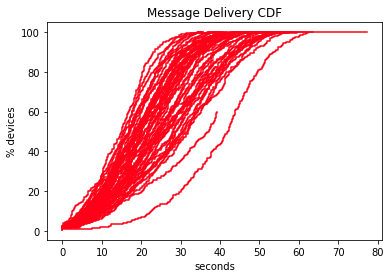

In [140]:
plot_group_received_points(sender_message_pairs, 100, 150)

In [114]:
# TODO why is the x axis sometimes super long (takes long time to deliver?)
weird_id = sender_message_pairs[82][1]
df[df['msg_id'] == weird_id]

,sender,receiver,type,msg_id,transimission_id,size,time,sim_id
3065874,836,803,msg,412,310806,384,47900,7415980
3065875,836,804,msg,412,310806,384,47900,7415980
3065876,836,867,msg,412,310806,384,47900,7415980
3065877,836,866,msg,412,310806,384,47900,7415980
3065878,836,835,msg,412,310806,384,47900,7415980
...,...,...,...,...,...,...,...,...
29110085,486,456,msg,412,2961658,384,275300,7415980
29110086,486,487,msg,412,2961658,384,275300,7415980
29110087,486,455,msg,412,2961658,384,275300,7415980
29110088,486,518,msg,412,2961658,384,275300,7415980


## Loops
- Does an original sender ever receive their own message?
    - this is actually allowed:
    
    Imagine A sends x to all neighbors. B receives x. C becomes a neighbor of A and does not have x. C asks B for x. B broadcasts x and A hears it.
    
    
- What we actually want to look at here is how long a message can be alive in the network and can one of the above loops happen after A has expired x.

    - look for A sends x and more than 5 minutes later A receives x
    - one way to think about this is "how often to messages take more than 5 minutes to deliver?"

## 95th percentile Scaling + Distance

make graph:

    x axis: number of people

    y axis: 90/5th percentile communication bandwidth
        do this for 3 ft apart, 5 ft apart, etc


In [178]:
people = [100, 200, 300, 400, 500, 600, 700, 800, 900]

dfs = [read_messages('../python/processing/logs/minutes_{minutes}_numDevices_{num_devices}_bitListInterval_{bitlist_interval}_move_{move}_uniform_{uniform}_uniformSpacing_{uniform_spacing}_sendRate_{send_rate}/'.format(
    minutes=MINUTES, 
    num_devices=people, 
    bitlist_interval=BITLIST_INTERVAL, 
    move=MOVE, 
    uniform=UNIFORM, 
    uniform_spacing=UNIFORM_SPACING, 
    send_rate=SEND_RATE)) for num_people in people]


In [179]:
incoming_bandwidths = [get_incoming_bandwidth(data) for data in dfs]
incoming_highs = [data['MB'].quantile(0.9) for data in incoming_bandwidths]

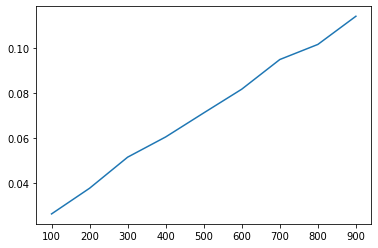

In [180]:
plt.plot(people, incoming_highs)
plt.show()

## Normal Distribution Parameters

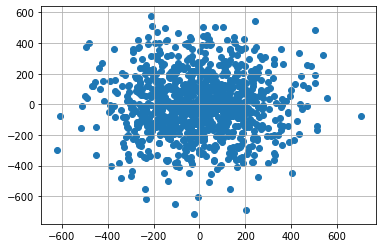

In [168]:
mean = 0
sd = 200
num_people = 1000
points = [(random.gauss(mean, sd), random.gauss(mean, sd)) for _ in range(num_people)]
xs, ys = zip(*points)
plt.grid(True)
plt.scatter(xs, ys)
plt.show()